In [25]:
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import datetime
import warnings 

from tqdm import tqdm
import os 

from src.plots import plot_series

warnings.filterwarnings('ignore')

### Data Preprocessing
Let's take a look at the data and do initial processing (missing values, anomalies...)

In [6]:
# Data Reading 
data = pd.read_csv('taxi_data/yellow_tripdata_2021-07.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2021-07-01 00:08:51,2021-07-01 00:13:05,1.0,0.8,1.0,N,90,68,1.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5
1,1.0,2021-07-01 00:22:39,2021-07-01 00:25:58,1.0,0.9,1.0,N,113,90,2.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5
2,1.0,2021-07-01 00:48:33,2021-07-01 00:54:58,1.0,2.8,1.0,N,88,232,2.0,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5
3,1.0,2021-07-01 00:59:44,2021-07-01 01:07:09,1.0,1.4,1.0,N,79,249,1.0,7.0,3.0,0.5,1.5,0.0,0.3,12.3,2.5
4,1.0,2021-07-01 00:08:35,2021-07-01 00:16:28,0.0,2.0,1.0,N,142,238,1.0,8.5,3.0,0.5,0.0,0.0,0.3,12.3,2.5


### Features Description 
The description of the features was obtained from: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

- `VendorID`: data provider (Two categories)
- `tpep_pickup_datetime`: trip start time
- `tpep_dropoff_datetime`: trip end time
- `passenger_count`: number of passengers
- `trip_distance`: trip distance in miles
- `RatecodeID`: rate type (Six categories)
- `store_and_fwd_flag`: indicates if the trip data was received immediately after the end of the trip, or was stored in the car's memory for some time (Binary)
- `PULocationID`: TLC Taxi Zone start a trip
- `DOLocationID`: TLC Taxi Zone end of a руtrip
- `payment_type`: payment method (Six categories)
- `fare_amount`: metered trip cost (time-distance)
- `tip_amount`: tip amount (credit card, if cash: doesn't count)


- `extra`: surcharge for trips during **peak hours and at night**
- `mta_tax`: meter tax
- `improvement_surcharge`: fare surcharge charged on every trip since January 2015
- `congestion_surcharge`: congestion surcharge


- `tolls_amount`: the amount of all tolls for the trip
- `total_amount`: total trip cost


### Additional  Info 
- `Borough`: a division of New York City. Allocate 5:
     - Bronx
     - Brooklyn
     - Manhattan
     - Queens
     - State Island
    
Еще есть зоны:
- EWR: Newark Liberty International Airport
- JFK: John Kennedy International Airport
- LGA: LaGuardia Airport

These areas are part of the New York area

- `Yellow Zone` - yellow taxi zone (green cannot pick up)

- `Boro Zone` - can pick up both green and yellow taxis

**We have to predict the number of trips in the coming hours in each New York district**

New York City areas (polygon data) were downloaded from (https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc)

**Data for different periods have different column formats**, for example, starting from 2016 we have `pickup_longitude pickup_latitude` and `dropoff_longitude dropoff_latitude` columns instead of `PULocationID` and `DOLocationID` columns.

Therefore, predictions can be made not only for the main districts but for rectangular parts (the number of such areas can be determined manually, for example, divided into 2500 rectangular parts or less)

In this project, we only use files with `PULocationID` and `DOLocationID` (files from 2017)

In [7]:
# Download NewYork city districts  
polygon_data = gpd.read_file('taxi_zones_polygons.geojson')
col_to_use = polygon_data.columns.to_list()[-4:]
polygon_data = polygon_data[col_to_use]

# Change type location_id to int
polygon_data['location_id'] = polygon_data['location_id'].apply(pd.to_numeric)

# Sort values 
polygon_data = polygon_data.sort_values(by='location_id').reset_index(drop=True)
polygon_data

,location_id,zone,borough,geometry
0,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
...,...,...,...,...
258,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ..."
259,260,Woodside,Queens,"MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ..."
260,261,World Trade Center,Manhattan,"MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ..."
261,262,Yorkville East,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [8]:
# It turns out there are incorrect (duplicate) `location_id`. Let's fix it
dup_indexes = polygon_data['location_id'][polygon_data['location_id'].duplicated()].index
polygon_data.loc[dup_indexes, :]

,location_id,zone,borough,geometry
56,56,Corona,Queens,"MULTIPOLYGON (((-73.85361 40.74750, -73.85325 ..."
103,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,"MULTIPOLYGON (((-74.03995 40.70089, -74.03945 ..."
104,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,"MULTIPOLYGON (((-74.01675 40.69334, -74.01540 ..."


Can be seen using `geometry` that these are different districts

In [9]:
# Fix location_id
polygon_data.loc[56, 'location_id'] = 57
polygon_data.loc[103, 'location_id'] = 104
polygon_data.loc[104, 'location_id'] = 105

In [10]:
# Exclude zones for which there is no polygon_data
unique_zones = polygon_data['location_id'].unique()
data = data[data['PULocationID'].isin(unique_zones)]

# Exclude zero number of passengers  (0 or NaN)
data = data[data['passenger_count'] != 0]
data = data[~data['passenger_count'].isnull()]

# Exclude zero distance
data = data[data['trip_distance'] != 0]

# Exclude zero trip duration and trips that have less than 35 seconds 
temp_series = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'])
res_indecies = temp_series[temp_series > pd.Timedelta("35 s")].index
data = data.loc[res_indecies, :]

### Duplicates
Features `tpep_pickup_datetime` and `tpep_dropoff_datetime` have duplicates

For example, consider `trip_distance == 0.06`

In [11]:
data[data['trip_distance'] == 0.06]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
221,2.0,2021-07-01 00:02:05,2021-07-01 00:03:06,1.0,0.06,1.0,N,132,132,3.0,-3.0,-0.5,-0.5,0.00,0.0,-0.3,-5.55,0.0
222,2.0,2021-07-01 00:02:05,2021-07-01 00:03:06,1.0,0.06,1.0,N,132,132,2.0,3.0,0.5,0.5,0.00,0.0,0.3,5.55,0.0
13366,2.0,2021-07-01 09:50:57,2021-07-01 10:04:41,1.0,0.06,1.0,N,229,229,1.0,9.0,0.0,0.5,0.01,0.0,0.3,12.31,2.5
15081,2.0,2021-07-01 09:18:34,2021-07-01 09:19:44,1.0,0.06,1.0,N,244,116,2.0,3.0,0.0,0.5,0.00,0.0,0.3,3.80,0.0
20087,2.0,2021-07-01 10:19:24,2021-07-01 10:20:55,1.0,0.06,1.0,N,234,234,2.0,3.0,0.0,0.5,0.00,0.0,0.3,6.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2630986,2.0,2021-07-31 12:40:30,2021-07-31 12:41:51,2.0,0.06,1.0,N,209,261,2.0,3.0,0.0,0.5,0.00,0.0,0.3,6.30,2.5
2670297,2.0,2021-07-31 19:56:55,2021-07-31 19:58:03,2.0,0.06,1.0,N,114,113,2.0,3.0,0.0,0.5,0.00,0.0,0.3,6.30,2.5
2682556,2.0,2021-07-31 22:41:43,2021-07-31 22:44:47,2.0,0.06,1.0,N,234,234,4.0,-2.5,-0.5,-0.5,0.00,0.0,-0.3,-6.30,-2.5
2682557,2.0,2021-07-31 22:41:43,2021-07-31 22:44:47,2.0,0.06,1.0,N,234,234,2.0,2.5,0.5,0.5,0.00,0.0,0.3,6.30,2.5


For such records, we have identical rows and negative values, for example, for `fare_amount` we get a negative trip cost

Several options why:
- Data Error (need to exclude duplicates for `tpep_pickup_datetime`)
- The client wanted to pay in one way, but then decided to change the payment method

**Solution:** We will remove such duplicates as it is very likely that this is a data error

In [12]:
print('Duplicated Records: ', data[['tpep_pickup_datetime']].duplicated().sum())

Duplicated Records:  1093144


There are many such records, almost half of the dataset

In [13]:
# Drop duplicates
data = data[~data[['tpep_pickup_datetime']].duplicated()]

In [14]:
# Fix negative values 
cols = ['fare_amount', 'extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']
for col in cols:
    data[col] = data[col].apply(lambda x: x*(-1) if x < 0 else x)

In [15]:
round(data[cols].describe(),2)

,fare_amount,extra,mta_tax,improvement_surcharge,total_amount,congestion_surcharge
count,1476566.00,1476566.00,1476566.00,1476566.0,1476566.00,1476566.00
mean,13.18,1.04,0.50,0.3,19.46,2.31
std,11.97,1.23,0.03,0.0,14.86,0.65
min,0.00,0.00,0.00,0.0,0.00,0.00
25%,6.50,0.00,0.50,0.3,11.75,2.50
50%,9.50,0.50,0.50,0.3,14.80,2.50
75%,14.50,2.50,0.50,0.3,20.75,2.50
max,1320.00,36.10,0.50,0.3,1320.80,2.50


No negative values

In [16]:
# Since it is necessary to predict the number of trips for a particular hour, then
# discard minutes and seconds in the start time of the trip (needed later for aggregation)
data = data.assign(tpep_pickup_datetime=pd.to_datetime(data['tpep_pickup_datetime'].dt.date) +
                    pd.to_timedelta(data['tpep_pickup_datetime'].dt.hour, unit='H'))

### Outlier Exclusion
Since we will be **predicting the number of trips or demand per hour in a particular district of New York**

We want trips to have the following properties:
- Done
- Non-zero duration and non-zero distance
- `passenger_count`: According to https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page no more than 6 people
- `RatecodeID`: exclude values that are not in the range from 1 to 6
- Current month (anomalous dates excluded)


Further thoughts:
- `driver_income`: add a new feature and remove entries that result in too high/low values of income per trip
- `trip_distance`: exclude values beyond +/- 3 sigma
- `improvement_surcharge` and `congestion_surcharge`: usually have constant values, check for negative values
- `fare_amount`,`tip_amount`, `extra`: check for negative values (data errors)
- `driver_income`: exclude values outside +/- 3 sigma
- `payment_type`: select only valid trips, don't have category 3, 4, 6

In [17]:
# The number of passengers must not exceed 6 people
data = data[~(data['passenger_count'] > 6)]

# Feature driver_income
data['driver_income'] = data['total_amount'] - data['mta_tax'] - data['tolls_amount']
round(data[['driver_income', 'trip_distance']].describe(), 2)

,driver_income,trip_distance
count,1476562.00,1476562.00
mean,18.57,3.34
std,13.75,4.66
min,0.00,0.01
25%,11.25,1.13
50%,14.30,1.90
75%,20.25,3.41
max,1320.30,643.30


In [18]:
# Let's look at the records where the driver did not earn anything
data[data['driver_income'] <= 0].head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,driver_income
162313,2.0,2021-07-02 21:00:00,2021-07-02 21:38:32,2.0,0.06,2.0,N,78,78,2.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0
282980,1.0,2021-07-04 19:00:00,2021-07-04 19:24:55,2.0,0.20,1.0,N,164,164,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282981,1.0,2021-07-04 19:00:00,2021-07-04 19:26:30,2.0,0.20,1.0,Y,164,164,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367073,1.0,2021-07-06 08:00:00,2021-07-06 08:37:35,2.0,0.20,1.0,N,113,249,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428861,1.0,2021-07-06 19:00:00,2021-07-06 19:11:22,3.0,3.10,1.0,N,186,186,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584589,1.0,2021-07-08 15:00:00,2021-07-08 15:18:00,2.0,0.40,1.0,N,141,237,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
604338,1.0,2021-07-08 18:00:00,2021-07-08 18:24:36,1.0,0.20,1.0,N,236,263,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
925340,1.0,2021-07-12 16:00:00,2021-07-12 16:44:55,1.0,4.20,1.0,N,234,239,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943160,1.0,2021-07-12 19:00:00,2021-07-12 19:14:26,2.0,0.20,1.0,N,161,161,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1166622,1.0,2021-07-15 09:00:00,2021-07-15 09:24:17,1.0,3.70,1.0,N,237,68,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It can be seen that the data was simply not recorded for such trips (zero values). 

**However, they were committed, for our task, we will not drop these values**

In [19]:
# Valid RatecodeID 
unique_rate_codes = np.arange(1,7)
rate_codes_to_drop = []
for code in data.RatecodeID.unique():
    if code not in unique_rate_codes:
        rate_codes_to_drop.append(code)
        
data = data[~(data['RatecodeID'].isin(rate_codes_to_drop))]

In [20]:
# There are dates outside the current month and anomalous dates, for example
# We loaded data for 2017, but we have observations from 2009
data = data.loc[(data.tpep_pickup_datetime.dt.year == 2021) & (data.tpep_pickup_datetime.dt.month == 7)]

### Data Aggregation

Let's group the data by districts and hours (should get a pair of district-time and number of trips)

In [21]:
sel_columns = ['tpep_pickup_datetime', 'PULocationID']
df = data[sel_columns]

# Group by hour and district and count the number of trips
df = df.groupby(['tpep_pickup_datetime', 'PULocationID']).size().reset_index(name='n_trips')
df

,tpep_pickup_datetime,PULocationID,n_trips
0,2021-07-01 00:00:00,4,2
1,2021-07-01 00:00:00,7,2
2,2021-07-01 00:00:00,13,2
3,2021-07-01 00:00:00,18,1
4,2021-07-01 00:00:00,24,3
...,...,...,...
55356,2021-07-31 23:00:00,255,5
55357,2021-07-31 23:00:00,256,6
55358,2021-07-31 23:00:00,261,10
55359,2021-07-31 23:00:00,262,15


Let's see how many trips were made this month in the `Times Sq/Theatre District` zone (PULocationID: 230)

In [22]:
print('N_trips in July 2017 (Times Sq/Theatre District): ', df.query('PULocationID == 230')['n_trips'].sum())

N_trips in July 2017 (Times Sq/Theatre District):  36517


Look at this Time Series

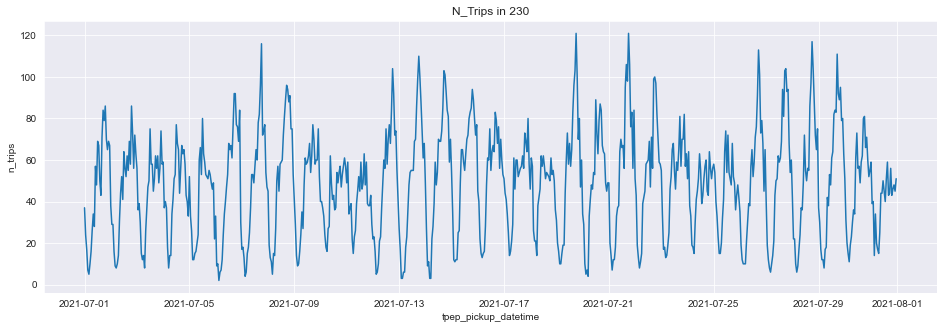

In [24]:
plot_series(df.query('PULocationID == 230'), city_zone=230)

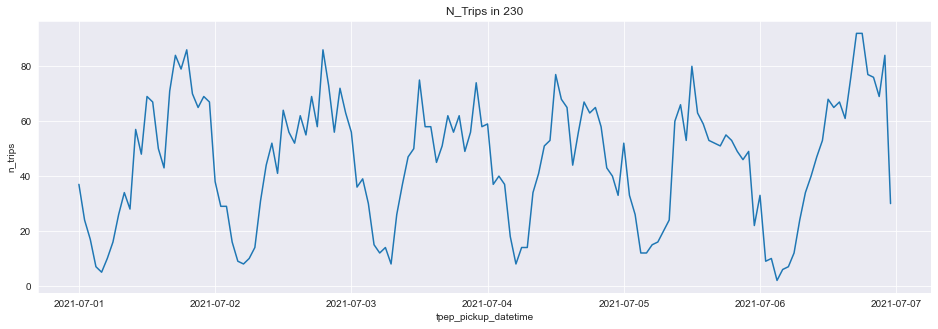

In [26]:
# Weekly Time Series 
tmp_df = df.query("PULocationID == 230 and   \
         tpep_pickup_datetime.dt.date.between(datetime.date(2021, 7, 1), datetime.date(2021, 7, 6))")

plot_series(tmp_df)

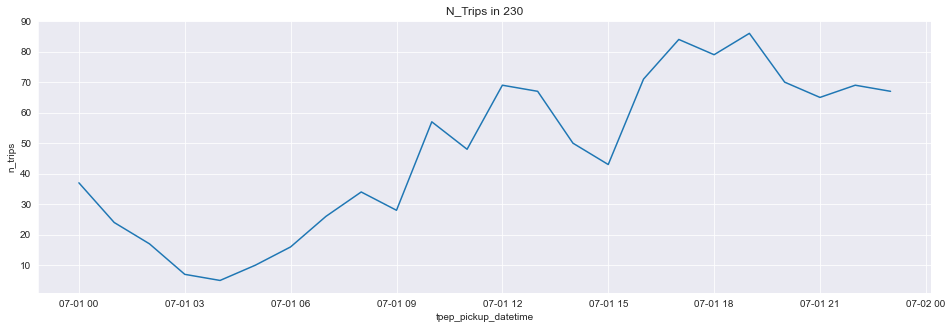

In [27]:
# Daily Time Series 
tmp_df = df.query("PULocationID == 230 and   \
         tpep_pickup_datetime.dt.date.between(datetime.date(2021, 7, 1), datetime.date(2021, 7, 1))")

plot_series(tmp_df)

You can see how the number of trips gradually decreases towards the night, then increases from 6:00 with a peak at 12:00, slightly decreases and the maximum peak (18:00) increases again. Such seasonality is observed in the entire series

Let's look at 5 random series

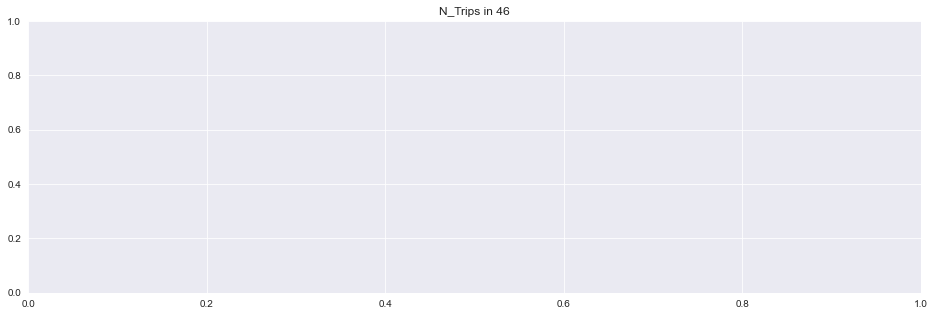

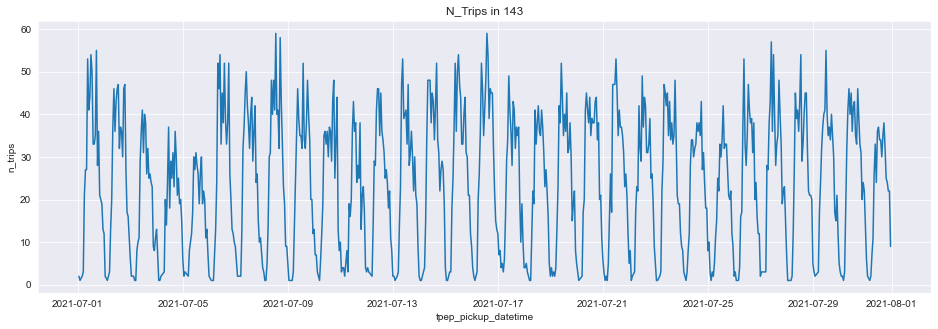

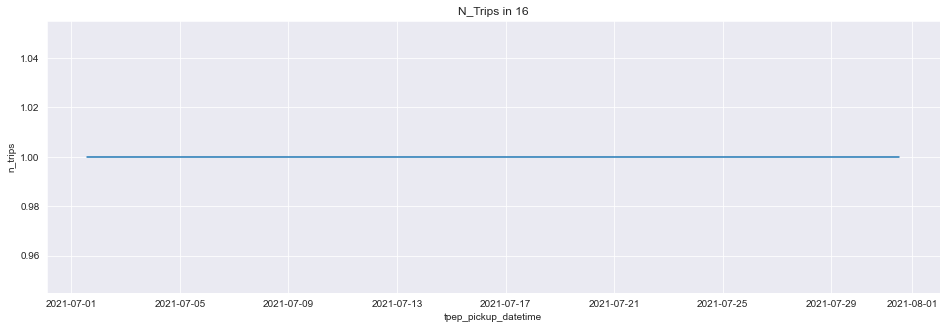

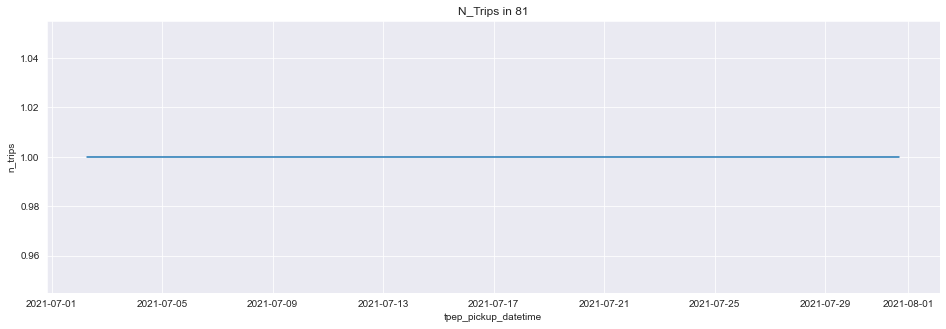

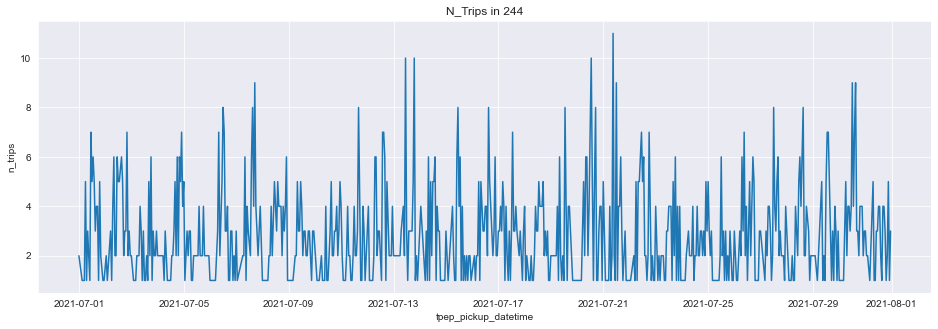

In [28]:
rand_zones = np.random.randint(1, 264, 5)
for zone in rand_zones:
    plot_series(df.query(f'PULocationID == {zone}'), city_zone=zone)

There are "good" series (enough data/no missing data) and "bad" (little data/zero values...) 

**For hour-district pairs for which there is no data, write 0**

In [29]:
unique_dates = pd.to_datetime(data['tpep_pickup_datetime'].unique())
unique_districts = set(polygon_data['location_id'].values)

In [30]:
# Fill in missing hour-district pairs with n_trips = 0
for date in unique_dates:
    zones_in_hour = set(df[df['tpep_pickup_datetime'] == date]['PULocationID']) # hour-district pairs that are present
    missing_zones = unique_districts.difference(zones_in_hour) # hour-district pairs that are missing
    
    # Add missing pairs to main df
    df = df.append(pd.DataFrame({
        'tpep_pickup_datetime': [date]*len(missing_zones),
        'PULocationID': list(missing_zones),
        'n_trips': [0]*len(missing_zones) 
    }))

df.reset_index(drop=True, inplace=True)

In [31]:
# Check the correctness for the very first date
df[df['tpep_pickup_datetime'] == unique_dates[0]].PULocationID.unique()

array([  4,   7,  13,  18,  24,  25,  33,  41,  43,  45,  48,  49,  50,
        61,  68,  70,  74,  75,  79,  80,  87,  88,  90,  97, 100, 107,
       113, 114, 116, 125, 132, 136, 137, 138, 140, 141, 142, 144, 145,
       146, 148, 151, 152, 158, 161, 162, 163, 164, 166, 168, 170, 179,
       181, 186, 209, 211, 224, 227, 229, 230, 231, 232, 233, 234, 236,
       237, 238, 239, 244, 246, 249, 255, 256, 261, 262, 263,   1,   2,
         3,   5,   6,   8,   9,  10,  11,  12,  14,  15,  16,  17,  19,
        20,  21,  22,  23,  26,  27,  28,  29,  30,  31,  32,  34,  35,
        36,  37,  38,  39,  40,  42,  44,  46,  47,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  62,  63,  64,  65,  66,  67,  69,
        71,  72,  73,  76,  77,  78,  81,  82,  83,  84,  85,  86,  89,
        91,  92,  93,  94,  95,  96,  98,  99, 101, 102, 103, 104, 105,
       106, 108, 109, 110, 111, 112, 115, 117, 118, 119, 120, 121, 122,
       123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 135, 13

You can easily see which areas of the city are missing (no records) for the time `2021-07-01 00:00:00`

There may be records for which a specific timestamp can be skipped, for such records we write zero

In [32]:
# Calculate the average number of trips per hour per month
df['time'] = df['tpep_pickup_datetime'].dt.time

mean_trip_hourly = df.groupby(['time', 'PULocationID'])['n_trips'].mean().reset_index(name='mean_n_trips')
mean_trip_hourly['mean_n_trips'] = round(mean_trip_hourly['mean_n_trips'])

### Trip Visualization
On the map you can visualize:
- Average number of trips per hour in a given district per month
- The number of trips in a certain district in each hour in a certain month

In [27]:
import plotly.express as px

In [28]:
# Attach zones and get rid of PULocationID
mean_trip_hourly = mean_trip_hourly.merge(polygon_data[['location_id', 'zone']],
                                          how='left', left_on='PULocationID', right_on='location_id').drop(columns=['PULocationID', 'location_id'])
mean_trip_hourly['time'] = mean_trip_hourly['time'].astype('str')
mean_trip_hourly

,time,mean_n_trips,zone
0,00:00:00,0.0,Newark Airport
1,00:00:00,0.0,Jamaica Bay
2,00:00:00,0.0,Allerton/Pelham Gardens
3,00:00:00,5.0,Alphabet City
4,00:00:00,0.0,Arden Heights
...,...,...,...
6307,23:00:00,0.0,Woodlawn/Wakefield
6308,23:00:00,0.0,Woodside
6309,23:00:00,8.0,World Trade Center
6310,23:00:00,8.0,Yorkville East


In [29]:
fig = px.choropleth(data_frame=mean_trip_hourly,
                    geojson=polygon_data, 
                    locations='zone',
                    featureidkey='properties.zone',
                    projection='mercator',
                    color='mean_n_trips',
                    color_discrete_map={'High':'red',
                                        'Moderate':'Yellow',
                                        'Low':'Green'},
                    
                    # range_color=(0, 12),
                    animation_frame='time')

fig.update_geos(fitbounds="locations", visible=False)
fig.show()

Now we can finish processing the data and move on to creating a Data Processing Pipeline (creating an ETL process)